## Cables

[Try this yourself](https://colab.research.google.com/github/DTUWindEnergy/TopFarm2/blob/master/docs/notebooks/cables.ipynb) (requires google account)


TOPFARM can use the Electrical Network Design package EDWIN to optimize the carray cabels as well as the substation position at each iteration of the layout optimization

**Install TOPFARM if needed**

In [1]:
# Install TopFarm if needed
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

  Cloning https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git to /tmp/pip-req-build-10_98kom
  Running command git clone --filter=blob:none --quiet https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git /tmp/pip-req-build-10_98kom
  Resolved https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git to commit fb5b0bb26f307630e7f06b000de4f1b0682e5305
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 62.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Install EDWIN if needed
import importlib
if not importlib.util.find_spec("ed_win"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/edwin.git#egg=ed_win[interarray]
    # fix ortools version
    !pip uninstall ortools -y
    !pip install ortools==9.6.2534

DEPRECATION: git+https://gitlab.windenergy.dtu.dk/TOPFARM/edwin.git#egg=ed_win[interarray] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
  Cloning https://gitlab.windenergy.dtu.dk/TOPFARM/edwin.git to /tmp/pip-install-35k8pe8i/ed-win_a94506ae0f554dbb917fa22b3d13be13
  Running command git clone --filter=blob:none --quiet https://gitlab.windenergy.dtu.dk/TOPFARM/edwin.git /tmp/pip-install-35k8pe8i/ed-win_a94506ae0f554dbb917fa22b3d13be13
  Resolved https://gitlab.windenergy.dtu.dk/TOPFARM/edwin.git to commit 517099b186a093556129aa75c968924861f9b9b1
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 44.2 MB/s e

### Import

In [3]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt

from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm._topfarm import TopFarmProblem, TopFarmGroup
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
from topfarm.plotting import XYPlotComp
from topfarm.utils import plot_list_recorder
from topfarm.cost_models.economic_models.dtu_wind_cm_main import economic_evaluation

from py_wake.examples.data.iea37._iea37 import IEA37_WindTurbines
from py_wake import BastankhahGaussian
from py_wake.examples.data.hornsrev1 import Hornsrev1Site

from ed_win.wind_farm_network import WindFarmNetwork

### Site

In [4]:
n_wt = 30
initial = np.asarray([np.random.random(30)*6000, np.random.random(30)*-10000]).T
x_init = initial[:,0]
y_init = initial[:,1]
boundary = np.array([(0, 0), (6000, 0), (6000, -10000), (0, -10000)])  # turbine boundaries
drivers = [EasyScipyOptimizeDriver(maxiter=10)]
windTurbines = IEA37_WindTurbines()
site = Hornsrev1Site()
wfm = BastankhahGaussian(site, windTurbines)


/usr/local/lib/python3.11/dist-packages/py_wake/deficit_models/gaussian.py:124: UserWarning: The BastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.gaussian_models.Bastankhah_PorteAgel_2014 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.gaussian_models.Bastankhah_PorteAgel_2014')


### Bathymetry

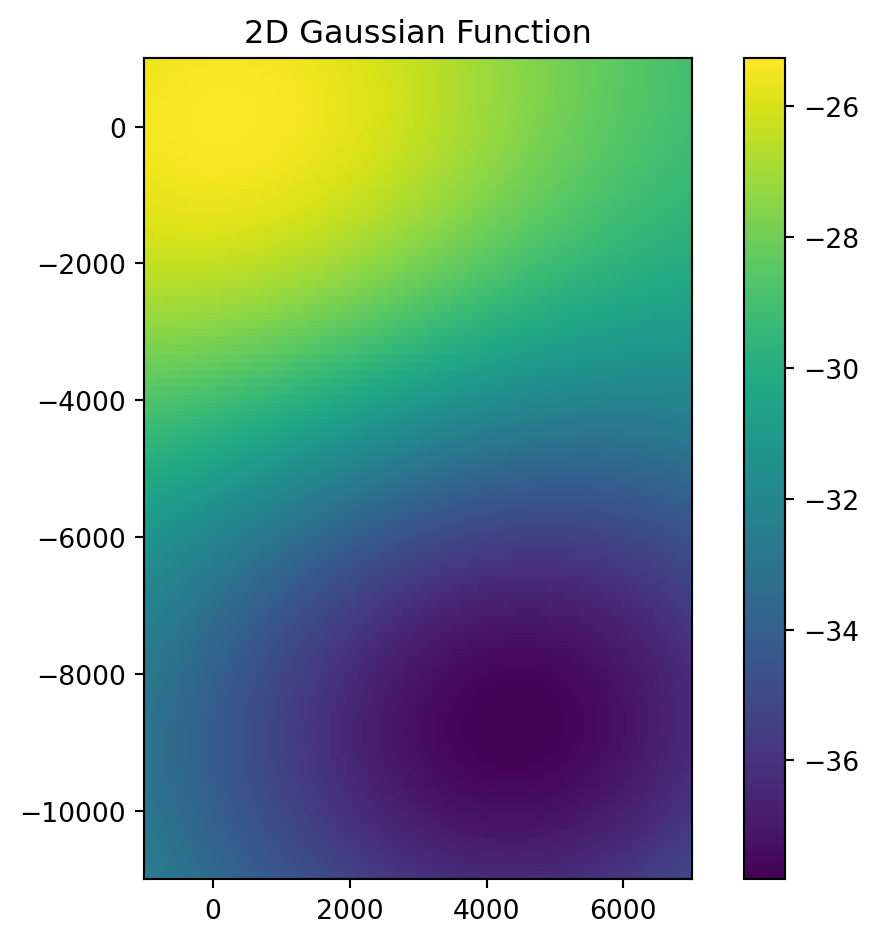

In [5]:
sigma = 3000.0
mu = 0.0

x_peak_1 = 1000
y_peak_1 = -1000
x_peak_2 = 4000
y_peak_2 = -8000
x1, y1 = np.meshgrid(np.linspace(0 - x_peak_1, 6000- x_peak_1, 100), np.linspace(-10000 - y_peak_1, 0 - y_peak_1, 100))
d1 = np.sqrt(x1*x1 + y1*y1)
g1 = np.exp(-((d1 - mu)**2 / (2.0 * sigma**2)))
x2, y2 = np.meshgrid(np.linspace(0 - x_peak_2, 6000- x_peak_2, 100), np.linspace(-10000 - y_peak_2, 0 - y_peak_2, 100))
d2 = np.sqrt(x2*x2 + y2*y2)
g2 = np.exp(-((d2 - mu)**2 / (2.0 * sigma**2)))
g = 5 * g1 - 8 * g2 - 30

plt.imshow(g, extent=(-1000, 7000, -11000, 1000), origin='lower', cmap='viridis')
plt.colorbar()
plt.title('2D Gaussian Function')
plt.show()

x = np.linspace(-1000, 7000, 100)
y = np.linspace(-11000, 1000, 100)

f = RegularGridInterpolator((x, y), g)

### Cables

Solving with heuristic(cpew)



<Axes: >

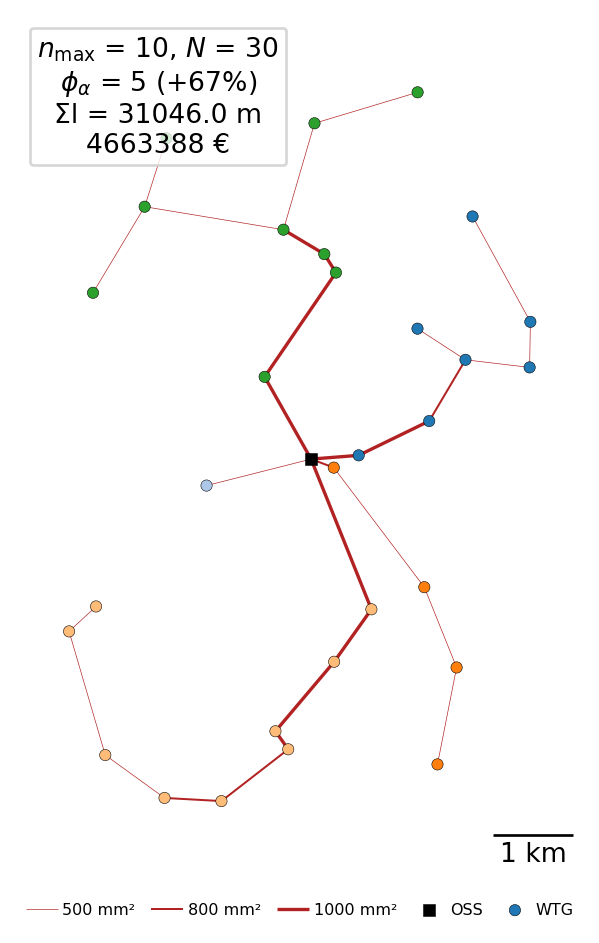

In [6]:
x_ss_init = x_init.mean()
y_ss_init = y_init.mean()
turbines_pos=np.asarray([x_init, y_init]).T
substations_pos = np.asarray([[x_ss_init], [y_ss_init]]).T

cables = np.array([[500, 3, 100], [800, 5, 150], [1000, 10, 250]])  # Here you set up cables [<cable cross section>, <number of turbines can be connected>, <price in € per meter>]

wfn = WindFarmNetwork(turbines_pos=turbines_pos, substations_pos=substations_pos, cables=cables)
G = wfn.optimize(turbines_pos)
cable_cost_ref = G.size(weight="cost")  # euro
cable_length_ref = G.size(weight="length")  # m
cost_per_length_ref = cable_cost_ref / cable_length_ref # euro / m

G.plot()

### Economy

In [7]:
Drotor_vector = [windTurbines.diameter()] * n_wt
power_rated_vector = [float(windTurbines.power(20))*1e-6] * n_wt
hub_height_vector = [windTurbines.hub_height()] * n_wt

# add additional cost model inputs for shore distance, energy price, project lifetime, rated rotor speed and water depth
distance_from_shore = 30         # [km]
energy_price = 0.1               # [Euro/kWh] What we get per kWh
project_duration = 25            # [years]
rated_rpm_array = [12] * n_wt    # [rpm]
simres = wfm(x_init, y_init)
aep = simres.aep().values.sum()
CF = aep / (windTurbines.power(20)*1e-9 * 24*365*n_wt)

eco_eval = economic_evaluation(distance_from_shore, energy_price, project_duration)
npv_ref = eco_eval.calculate_npv(rated_rpm_array, Drotor_vector, power_rated_vector, hub_height_vector, 30, aep/n_wt * np.ones(n_wt)*10**6, cabling_cost=cable_cost_ref)

### Python Functions

In [8]:
# Water Depth
def water_depth_func(x, y, **kwargs):
    xnew, ynew = np.meshgrid(x, y)
    points = np.array([xnew.flatten(), ynew.flatten()]).T
    return - np.diag(f(points).reshape(n_wt, n_wt).T)

# Cables
def cable_func(x, y, x_substation, y_substation, **kwargs):
    G = wfn.optimize(turbines_pos= np.asarray([x, y]).T, substations_pos=np.asarray([[float(x_substation[0])], [float(y_substation[0])]]).T)
    return G.size(weight="cost"), {'cabling_length': G.size(weight="length")}

# Economy
def npv_func(AEP, water_depth, cabling_cost, **kwargs):
    eco_eval.calculate_npv(rated_rpm_array, Drotor_vector, power_rated_vector, hub_height_vector, water_depth, AEP/n_wt * np.ones(n_wt)*10**6, cabling_cost=cabling_cost)
    eco_eval.calculate_irr(rated_rpm_array, Drotor_vector, power_rated_vector, hub_height_vector, water_depth, AEP/n_wt * np.ones(n_wt)*10**6, cabling_cost=cabling_cost)
    CAPEX = eco_eval.project_costs_sums["CAPEX"]
    OPEX = eco_eval.project_costs_sums["OPEX"]
    return eco_eval.NPV, {'irr': eco_eval.IRR,
                          'OPEX': OPEX,
                          'CAPEX': CAPEX,}


### Components

In [9]:
# Water Depth
water_depth_component = CostModelComponent(input_keys=[('x', x_init),('y', y_init)],
                                          n_wt=n_wt,
                                          cost_function=water_depth_func,
                                          objective=False,
                                          output_keys=[('water_depth', np.zeros(n_wt))])

# Cables
cable_component = CostModelComponent(input_keys=[('x', x_init),('y', y_init), ('x_substation', x_ss_init), ('y_substation', y_ss_init)],
                                     n_wt=n_wt,
                                     cost_function=cable_func,
                                     objective=False,
                                     output_keys=[('cabling_cost', 0)],
                                     additional_output=[('cabling_length', 0)])

# Economy
npv_comp = CostModelComponent(input_keys=[('AEP', 0), ('water_depth', 30*np.ones(n_wt)), ('cabling_cost', 100000)],
                              n_wt=n_wt,
                              cost_function=npv_func,
                              objective=True,
                              maximize=True,
                              output_keys=[('npv', 0)],
                              additional_output=[('irr', 0),
                                                 ('CAPEX', 0),
                                                 ('OPEX', 0)])

# AEP
aep_comp = PyWakeAEPCostModelComponent(wfm, n_wt, objective=False)

### Problem Assembly

In [10]:
cost_comp = TopFarmGroup([PyWakeAEPCostModelComponent(wfm, n_wt, objective=False), water_depth_component, cable_component, npv_comp])


tf = TopFarmProblem(
    design_vars=dict(zip('xy', initial.T), x_substation=x_ss_init, y_substation=y_ss_init),
    cost_comp=cost_comp,
    constraints=[XYBoundaryConstraint(boundary),
                 SpacingConstraint(500)
                 ],
    driver=drivers[0],
    plot_comp=XYPlotComp()
)


INFO: checking out_of_order...


INFO:check_config:checking out_of_order...


INFO:     out_of_order check complete (0.002458 sec).


INFO:check_config:    out_of_order check complete (0.002458 sec).


INFO: checking system...


INFO:check_config:checking system...


INFO:     system check complete (0.000061 sec).


INFO:check_config:    system check complete (0.000061 sec).


INFO: checking solvers...


INFO:check_config:checking solvers...


INFO:     solvers check complete (0.001715 sec).


INFO:check_config:    solvers check complete (0.001715 sec).


INFO: checking dup_inputs...


INFO:check_config:checking dup_inputs...


INFO:     dup_inputs check complete (0.000111 sec).


INFO:check_config:    dup_inputs check complete (0.000111 sec).


INFO: checking missing_recorders...


INFO:check_config:checking missing_recorders...


INFO:     missing_recorders check complete (0.000008 sec).


INFO:check_config:    missing_recorders check complete (0.000008 sec).


INFO: checking unserializable_options...


INFO:check_config:checking unserializable_options...


INFO:     unserializable_options check complete (0.001250 sec).


INFO:check_config:    unserializable_options check complete (0.001250 sec).


INFO: checking comp_has_no_outputs...


INFO:check_config:checking comp_has_no_outputs...


INFO:     comp_has_no_outputs check complete (0.000106 sec).


INFO:check_config:    comp_has_no_outputs check complete (0.000106 sec).


INFO: checking auto_ivc_warnings...


INFO:check_config:checking auto_ivc_warnings...


INFO:     auto_ivc_warnings check complete (0.000007 sec).


INFO:check_config:    auto_ivc_warnings check complete (0.000007 sec).


### Optimize

INFO: checking out_of_order...


INFO:check_config:checking out_of_order...


INFO:     out_of_order check complete (0.001608 sec).


INFO:check_config:    out_of_order check complete (0.001608 sec).


INFO: checking system...


INFO:check_config:checking system...


INFO:     system check complete (0.000048 sec).


INFO:check_config:    system check complete (0.000048 sec).


INFO: checking solvers...


INFO:check_config:checking solvers...


INFO:     solvers check complete (0.000997 sec).


INFO:check_config:    solvers check complete (0.000997 sec).


INFO: checking dup_inputs...


INFO:check_config:checking dup_inputs...


INFO:     dup_inputs check complete (0.000073 sec).


INFO:check_config:    dup_inputs check complete (0.000073 sec).


INFO: checking missing_recorders...


INFO:check_config:checking missing_recorders...


INFO:     missing_recorders check complete (0.000007 sec).


INFO:check_config:    missing_recorders check complete (0.000007 sec).


INFO: checking unserializable_options...


INFO:check_config:checking unserializable_options...


INFO:     unserializable_options check complete (0.000285 sec).


INFO:check_config:    unserializable_options check complete (0.000285 sec).


INFO: checking comp_has_no_outputs...


INFO:check_config:checking comp_has_no_outputs...


INFO:     comp_has_no_outputs check complete (0.000080 sec).


INFO:check_config:    comp_has_no_outputs check complete (0.000080 sec).


INFO: checking auto_ivc_warnings...


INFO:check_config:checking auto_ivc_warnings...


INFO:     auto_ivc_warnings check complete (0.000005 sec).


INFO:check_config:    auto_ivc_warnings check complete (0.000005 sec).


Solving with heuristic(cpew)



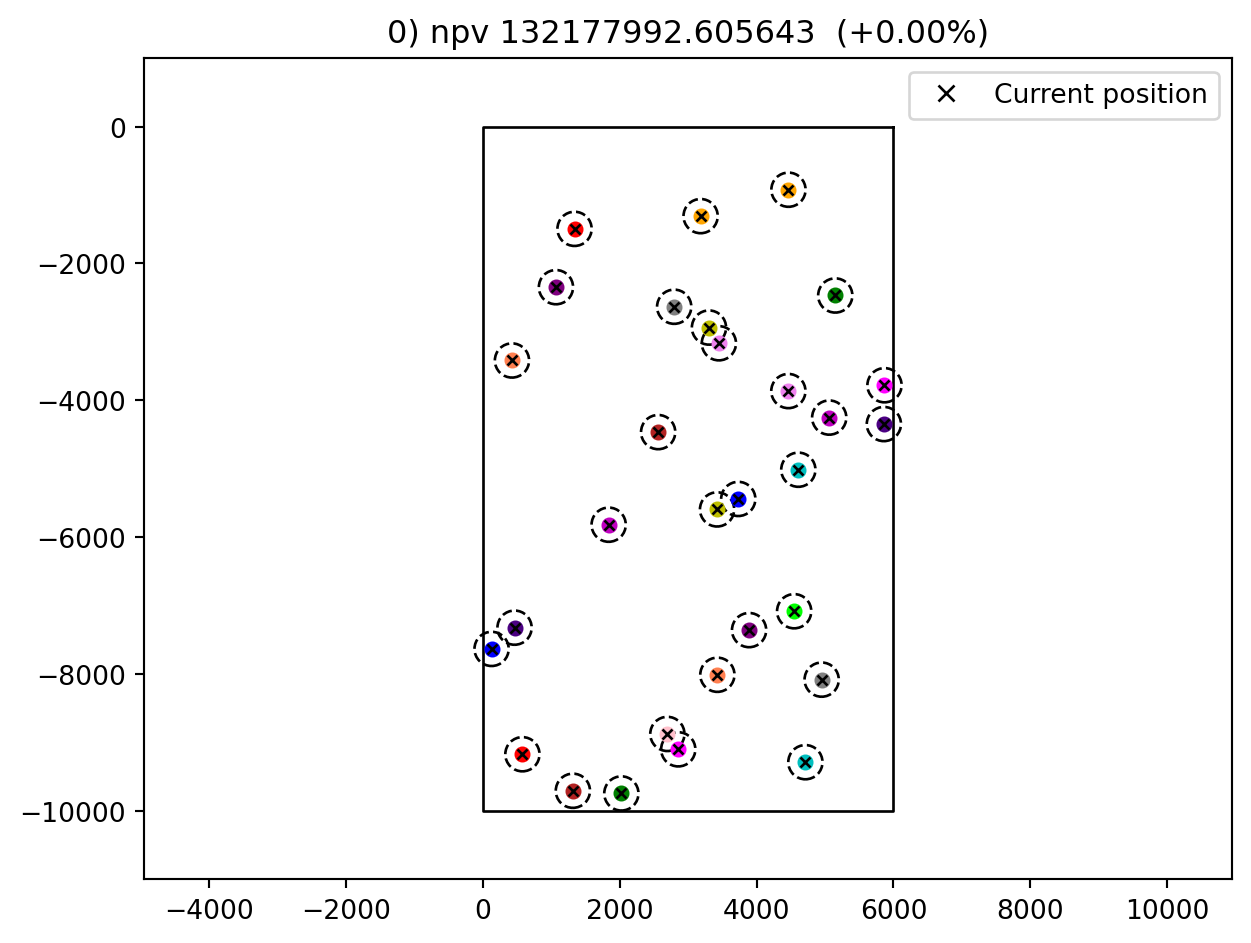

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving wi

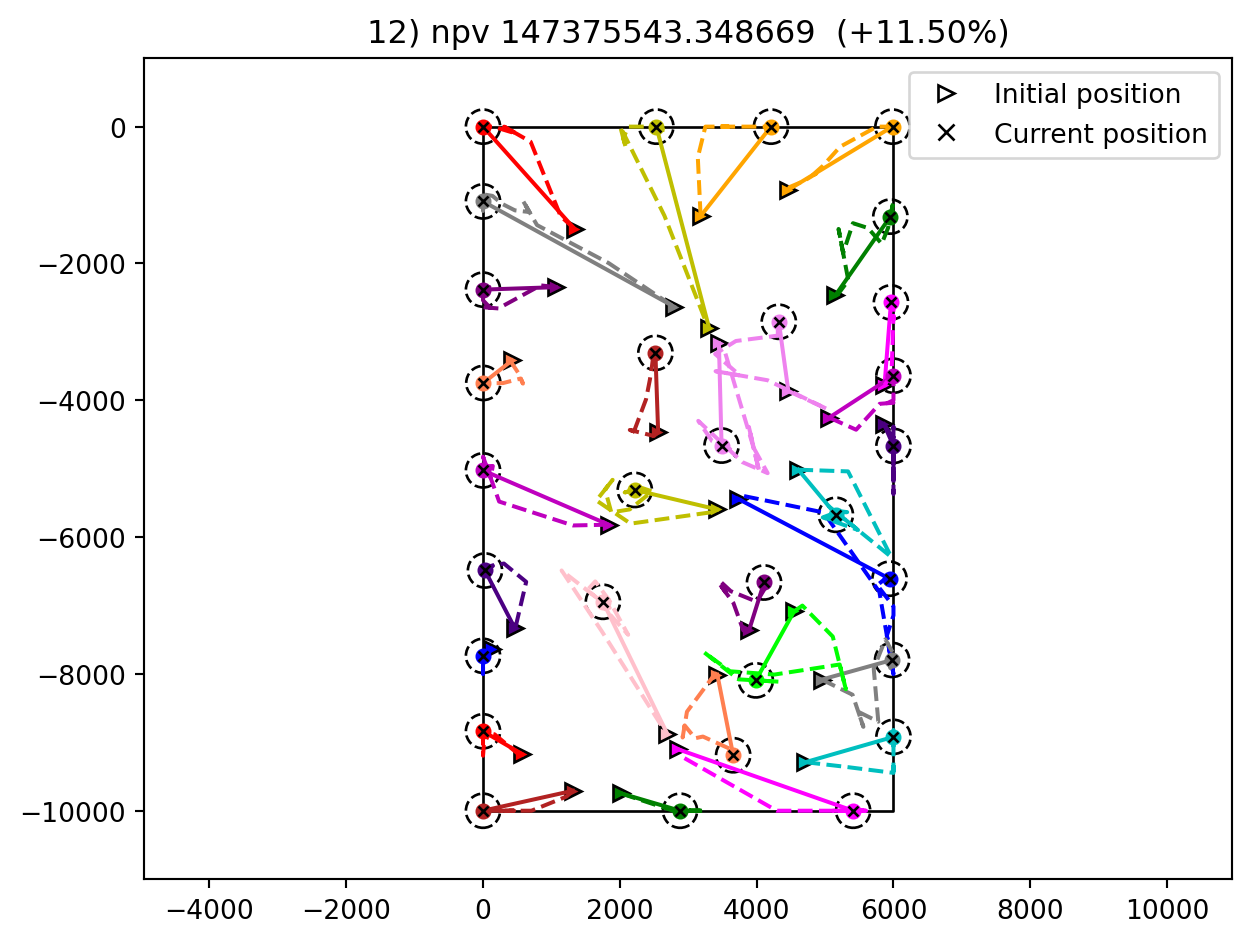

In [11]:
cost, _, recorder = tf.optimize()


### Plot

/usr/local/lib/python3.11/dist-packages/topfarm/utils.py:602: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


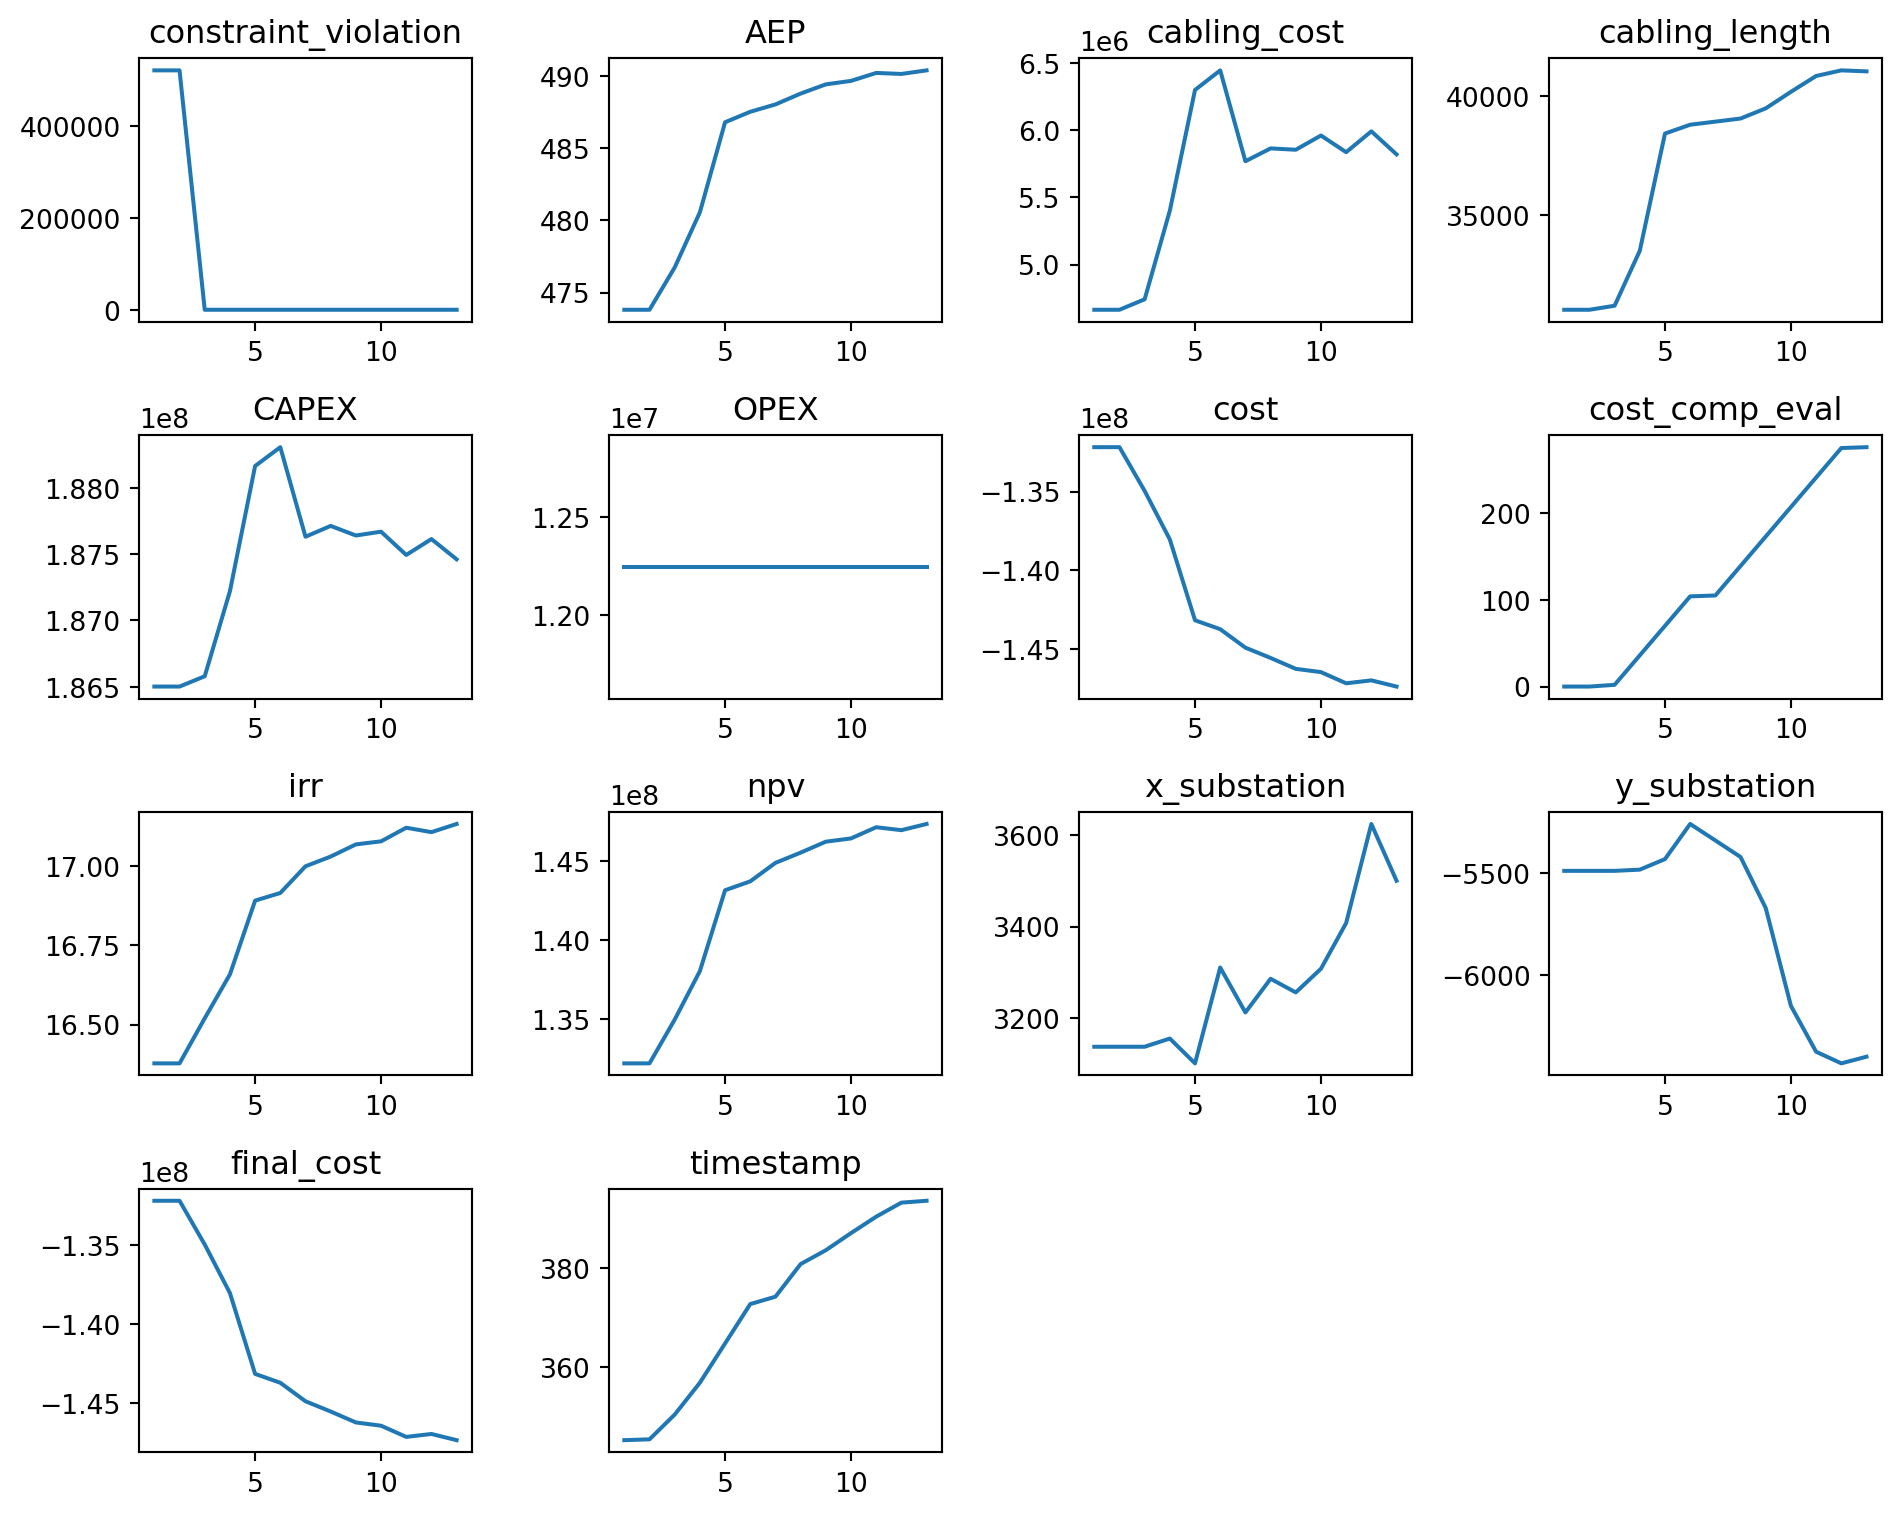

In [12]:
plot_list_recorder(recorder)

Solving with heuristic(cpew)



<Axes: >

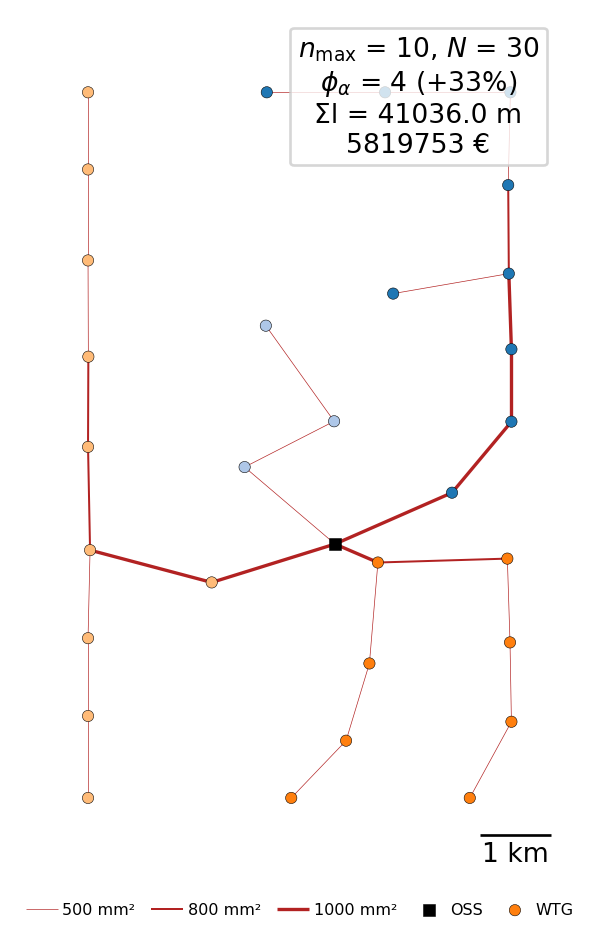

In [13]:
x_opt = recorder['x'][-1]
y_opt = recorder['y'][-1]
x_sub_opt = recorder['x_substation'][-1]
y_sub_opt = recorder['y_substation'][-1]
G = wfn.optimize(np.asarray([x_opt, y_opt]).T,
                 substations_pos=np.asarray([[float(x_sub_opt)], [float(y_sub_opt)]]).T,
                 )
G.plot()


**End of exercise!**